# NLP Assignment 2 (40% of grade): Vector Space Semantics for Similarity between Friends Characters

In this assignment, you will be creating a vector representation of a document containing lines spoken by a character in the Friends script data (i.e. from the file `training.csv`), then improving that representation such that each character vector is maximally distinguished from the other character documents. This distinction is measured by how well a simple information retrieval classification method can select documents from validation and test data as belonging to the correct class of document (i.e. deciding which character spoke the lines by measuring the similarity of those character document vectors to those built in training).

As the lines are not evenly distributed in terms of frequency, this coursework stipulates you can only use a maximum of the first **300 lines** of each character in the training data `training.csv` to create the training documents and a maximum of the first **30 lines** in the validation and test data (from `val.csv` and `test.csv`). This makes it more challenging, as the number of lines spoken by a character can't be used directly or otherwise as a feature.

A simple vector representation for each character document is done for you to start with in this code, as is the pipeline of similarity-based information retrieval evaluation. You need to improve the character vector representations by pre-processing, feature extraction and transformation techniques, as per Questions 1-6 below, which you need to complete as instructed.

**Refer to the material in units 8-9 for conceptual background.**

In [1]:
!pip install nltk
!pip install pyspellchecker
!pip install textblob

In [2]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import math

import nltk
from nltk import pos_tag

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix, hstack
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import defaultdict
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.decomposition import SparsePCA

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


%matplotlib inline
pd.options.display.max_colwidth=500

In [3]:
# Read training data and show it in a table using pandas
train_path='training.csv'
train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
val_path ='val.csv'
val_data = pd.read_csv(val_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspecting
train_data

,Episode,Scene,Character_name,Line,Gender
0,s01e01,c01,Monica Geller,There's nothing to tell! He's just some guy I work with!,Female
1,s01e01,c01,Joey Tribbiani,"C'mon, you're going out with the guy! There's gotta be something wrong with him!",Male
2,s01e01,c01,Chandler Bing,"All right Joey, be nice. So does he have a hump? A hump and a hairpiece?",Male
3,s01e01,c01,Phoebe Buffay,"Wait, does he eat chalk?",Female
4,s01e01,c01,Phoebe Buffay,"Just, 'cause, I don't want her to go through what I went through with Carl- oh!",Female
...,...,...,...,...,...
53548,s03e25,c12,Ross Geller,Hi.,Male
53549,s03e25,c13,Chandler Bing,Hi there.,Male
53550,s03e25,c13,Monica Geller,That's that weird voice again.,Female
53551,s03e25,c13,Chandler Bing,"Okay! Okay! Let me try it again, you're gonna wanna date this next guy, I swear!",Male


# Q3. Add dialogue context and scene features (15 marks)
Adjust `create_character_document_from_dataframe` and the other functions appropriately so the data incorporates the context of the line spoken by the characters in terms of the lines spoken by other characters in the same scene (before and after the target character's lines). HINT: you should use the *Episode* and *Scene* columns to check which characters are in the same scene to decide whether to include their lines or not. Only the lines from the same *Scene* can be added as the context as lines from different *Scene* are irrelevant.  **(but DO NOT USE the GENDER and CHARACTER columns directly)**.

# Answer 3

In [4]:
'''
Create one document per character
generates the context for each character as well
two output - character lines & character context
character_docs- list[(name1, doc1), (name2, doc2)...]
character_context_docs- list[(name1, context_lines1), (name2, context_lines2)...]

Context is chosen based on param context_window
'''

def create_character_document_from_dataframe(df, max_line_count, context_window=1):
    """
    Make documents for each character using their lines and nearby lines for context.

    :param df: A table with the script data.
    :param max_line_count: How many lines each character can have at most.
    :param context_window: How many lines around a character's line to include for context.
    :return: Two dictionaries, one with lines and one with context, both organized by character.
    """
    character_lines = {}
    character_context = {}
    character_line_count = {}
    scene_lines = {}

    for index, row in df.iterrows():
        name = row['Character_name']
        line = row['Line']
        episode = row['Episode']
        scene = row['Scene']

        # Don't use lines that are empty
        if pd.isna(line) or line == "":
            continue

        # Make sure each character has a list to add lines to
        if name not in character_lines:
            character_lines[name] = []
            character_context[name] = []
            character_line_count[name] = 0

        # Stop if a character has too many lines already
        if character_line_count[name] >= max_line_count:
            continue

        # Make lists for each episode and scene if they don't exist
        if episode not in scene_lines:
            scene_lines[episode] = {}
        if scene not in scene_lines[episode]:
            scene_lines[episode][scene] = []

        # Adding the current line to the scene
        scene_lines[episode][scene].append((name, line))

        # Collecting lines around the current one for context
        current_context = [context_line for context_name, context_line in scene_lines[episode][scene] if context_name != name]

        # Keeping only the most recent lines for context, as many as the context window allows
        if len(current_context) > 2 * context_window:
            current_context = current_context[-(2 * context_window):]

        # Storing the line and its context
        character_lines[name].append(line)
        character_context[name].append(' _EOL_ '.join(current_context))
        character_line_count[name] += 1

    # Showing how many lines each character has
    print("Lines per character:", {k: len(v) for k, v in character_lines.items()})
    return character_lines, character_context


In [5]:
train_character_docs, train_context_docs = create_character_document_from_dataframe(train_data, max_line_count=300, context_window = 1)

Lines per character: {'Monica Geller': 300, 'Joey Tribbiani': 300, 'Chandler Bing': 300, 'Phoebe Buffay': 300, '#ALL#': 300, 'Ross Geller': 300, 'Rachel Green': 300, 'Other_None': 300, 'Other_Female': 300, 'Other_Male': 300}


# Q1. Improve pre-processing (20 marks)
Using the pre-processing techniques you have learned in the module, improve the `pre_process` function above, which currently just tokenizes text based on white space.

When developing, use the first 300 and 30 lines from the training and validation files, as per above. To check the improvements by using the different techniques, use the `compute_IR_evaluation_scores` function as above. The **mean rank** is the main metric you need to focus on improving throughout this assignment, where the target/best possible performance is **1** (i.e. all test/validation data character documents are closest to their corresponding training data character documents) and the worst is **10**. Initially, the code in this template achieves a mean rank of **4.0**  and accuracy of **0.3** on the test set and a mean rank of **4.2** and accuracy of **0.1** on the validation set - you should be looking to improve those, particularly getting the mean rank as close to 1 as possible.


#Answer 1

In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from spellchecker import SpellChecker
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

def pre_process(character_text, tokenize = True, lower = True, remove_punct = True, remove_stopwords = False, spell_checker = False, lemmatize = True):
    """Pre-process all the concatenated lines of a character,
    using tokenization, spelling normalization and other techniques.

    Initially just a tokenization on white space. Improve this for Q1.

    ::character_text:: a string with all of one character's lines
    """

    try :
        # Tokenization
        if tokenize is True :
            tokens = word_tokenize(character_text)

        #removing punctuation
        if remove_punct is True :
            tokens = [token for token in tokens if token not in string.punctuation]

        #lowercase conversion
        if lower is True :
            tokens = [token.lower() for token in tokens]

        # Stopword removal
        if remove_stopwords is True :
            stop_words = set(stopwords.words('english'))
            tokens = [word for word in tokens if word not in stop_words]

        # Spelling correction
        if spell_checker is True :
            spell = SpellChecker()
            tokens = [spell.correction(word) for word in tokens]

        # Lemmatization
        if lemmatize is True :
            lemmatizer = WordNetLemmatizer()
            tokens = [lemmatizer.lemmatize(word) for word in tokens if word is not None]

        # return tokens
        tokens = [token for token in tokens if token is not None]
        return ' '.join(tokens)

    except Exception as e :
        print(f"Exception occured in preprocessing : {e}")
        print(f"Reverting to basic .split(\s)")
        return character_text.split()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
#Creating  training set  corpus of character docs
training_corpus = []
for name, doc in train_character_docs.items() :
    character_tuple = (name, [])
    for line in doc :
        processed_line = pre_process(line)
        character_tuple[1].append([processed_line])
    training_corpus.append(character_tuple)

train_labels = [name for name, doc in training_corpus]

#Creating  the training corpus of context docs
training_context_corpus = []
for name, doc in train_context_docs.items() :
    character_tuple = (name, [])
    for line in doc :
        processed_line = pre_process(line)
        character_tuple[1].append([processed_line])
    training_context_corpus.append(character_tuple)


# Q2. Improve linguistic feature extraction (30 marks)
Use the feature extraction techniques you have learned to improve the `to_feature_vector_dictionary` and `create_document_matrix_from_corpus` functions above. Examples of extra features could include extracting n-grams of different lengths and including POS tags. You could also use sentiment analysis or another text classifier's result when applied to the features for each character document. You could even use a gender classifier trained on the same data using the GENDER column **(but DO NOT USE the GENDER column directly in the features for the final vector)**.

Matrix transformation techniques like TF-IDF (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) are commonly used to improve the `create_document_matrix_from_corpus` function, which currently only uses a dictionary vectorizer (`DictVectorizer`) which straight-forwardly maps from the feature dictionaries produced for each character document to a sparse matrix.

Other options include using feature selection/reduction with techniques like minimum/maximum document frequency and/or feature selection like k-best selection using different statistical tests https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html.

Again, develop your system using the training and validation sets and note the effect/improvement in mean rank with the techniques you use.

#Answer 2

In [8]:
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
sia = SentimentIntensityAnalyzer()


def extract_pos_tags(character_doc):
    """
    Extracts POS tags from a list of tokens.

    ::character_doc:: a list of lists of lines
    :return: a list of POS tags corresponding to the tokens
    """
    if character_doc is None or not character_doc:
        return []

    # POS Tagging
    pos_tags = []
    for line in character_doc :
        tagged = pos_tag(line[0].split())
        tagged = [tag if tag is not None else '' for word,tag in tagged]
        pos_tags.append(' '.join(tagged))

    # return pos_tags
    return ' '.join(pos_tags)


def get_sentiment_scores(line, vader = False):
    """Returns sentiment polarity and subjectivity of the given line of speech."""
    analysis = TextBlob(line)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity

def aggregate_character_sentiments(character_docs):
    """Aggregates sentiment scores for each character."""
    character_sentiments = []
    polarity_scores = []
    subjectivity_scores = []
    for line in character_docs:
        polarity, subjectivity = get_sentiment_scores(line[0])
        polarity_scores.append(polarity)
        subjectivity_scores.append(subjectivity)

    character_sentiments = [np.mean(polarity_scores), np.mean(subjectivity_scores)]
    return [np.mean(character_sentiments)]

res = aggregate_character_sentiments(training_corpus[0][1])
print(res)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[0.1557094051781552]


In [9]:
def to_feature_vector_dictionary(character_doc, extra_features):
    """Turns a list of cleaned-up words and extra stuff about the character
    into a format that's easy to use later on.

    Right now, it just counts the words. You can make it fancier for Q2.

    ::character_doc:: a list of cleaned-up words
    ::extra_features:: any extra stuff about the character you want to add
    """

    if character_doc is None:
        # If there's nothing in the list, just use an empty string
        processed_text = ''
    else:
        # Make sure everything in the list is text and ignore any 'None' values
        processed_tokens = [str(token) for token in character_doc if token is not None]

    processed_text = ' '.join(processed_tokens)  # Stick all the words together into one big string
    # If you have extra stuff to add about the character, it goes here
    return processed_text



In [10]:
corpusVectorizer = DictVectorizer()

tfidfVectorizer  = TfidfVectorizer()     # Used to convert character docs into numerical format
posVectorizer = TfidfVectorizer()        # Converts POS tags into a numerical format
contextVectorizer = TfidfVectorizer()    # Transforms context documents into numerical format

def create_document_matrix_from_corpus(corpus, fitting=False, weights = [1,1,1,1], **kwargs):
    """Turns text data into a numerical matrix using various vectorizers.

    Right now, it just turns the text into a matrix using TfidfVectorizer. You can expand it for Q2.

    ::corpus:: list of (class_label, document) pairs.
    ::fitting:: whether to train the vectorizers (true for training data).
    """

    # Assign weights to different types of features
    tfidf_weight = weights[0]
    pos_weight = weights[1]
    sentiment_weight = weights[2]
    context_weight = weights[3]

    # Process each document in the corpus and convert it into a feature vector
    final_features = []
    for name, doc in corpus:
        final_features.append(to_feature_vector_dictionary(doc, []))

    # Train the TfidfVectorizer if necessary and then transform the documents
    if fitting:
        tfidfVectorizer.fit(final_features)
    doc_feature_matrix = tfidfVectorizer.transform(final_features)
    weighted_doc_feature_matrix = doc_feature_matrix.multiply(tfidf_weight)
    combined_features = weighted_doc_feature_matrix

    # Convert POS tags to features using TF-IDF if specified
    try:
        if kwargs['pos']:
            pos_tags = [extract_pos_tags(doc) for name, doc in corpus]
            if fitting:
                posVectorizer.fit(pos_tags)
            pos_feature_matrix = posVectorizer.transform(pos_tags)
            weighted_pos_matrix = csr_matrix(pos_feature_matrix).multiply(pos_weight)
            combined_features = hstack([combined_features, weighted_pos_matrix])
    except Exception as e:
        print(f"Error in POS tag processing: {e}")

    # Include sentiment analysis features if specified
    try:
        if kwargs['sentiment']:
            character_sentiment = [aggregate_character_sentiments(doc) for name, doc in corpus]
            sentiment_matrix = csr_matrix(np.array(character_sentiment))
            weighted_sentiment_matrix = sentiment_matrix.multiply(sentiment_weight)
            combined_features = hstack([combined_features, weighted_sentiment_matrix])
    except Exception as e:
        print(f"Error in sentiment analysis: {e}")

    # Include context analysis features if specified
    try:
        if kwargs['context']:
            context_corpus = kwargs['context_corpus']
            final_context_features = [to_feature_vector_dictionary(doc, []) for name, doc in context_corpus]
            if fitting:
                contextVectorizer.fit(final_context_features)
            context_feature_matrix = contextVectorizer.transform(final_context_features)
            weighted_context_feature_matrix = context_feature_matrix.multiply(context_weight)
            combined_features = hstack([combined_features, weighted_context_feature_matrix])
    except Exception as e:
        print(f"Error in context analysis: {e}")

    return combined_features

# Example of using this function with a training corpus
training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True, weights = [1.0, 0.25, 0.5, 0.5], pos=True, sentiment=True, context=True, context_corpus=training_context_corpus)


In [11]:
training_feature_matrix
# print(training_feature_matrix.shape)

<10x5088 sparse matrix of type '<class 'numpy.float64'>'
	with 13939 stored elements in Compressed Sparse Row format>

In [12]:

val_character_docs, val_context_docs = create_character_document_from_dataframe(val_data, max_line_count=30, context_window = 1)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")

# create list of pairs of (character name, pre-processed character)
val_corpus = []
for name, doc in val_character_docs.items() :
    # if(name == '#ALL#') :
    #     continue
    character_tuple = (name, [])
    for line in doc :
        processed_line = pre_process(line)
        character_tuple[1].append([processed_line])
    val_corpus.append(character_tuple)

val_labels = [name for name, doc in val_corpus]


#Create the validation corpus of context docs
val_context_corpus = []
for name, doc in val_context_docs.items() :
    character_tuple = (name, [])
    for line in doc :
        processed_line = pre_process(line)
        character_tuple[1].append([processed_line])
    val_context_corpus.append(character_tuple)

Lines per character: {'Other_None': 30, 'Rachel Green': 30, 'Other_Male': 30, 'Ross Geller': 30, '#ALL#': 18, 'Phoebe Buffay': 30, 'Chandler Bing': 30, 'Monica Geller': 30, 'Joey Tribbiani': 30, 'Other_Female': 30}
Num. Characters:  10 



In [13]:
# Just transforming the val_feature_matrix, don't fit
# val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False, sentiment=True)
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False, weights = [1.0, 0.25, 0.5, 0.5], pos = True, sentiment=True, context = True, context_corpus = val_context_corpus)

In [14]:
val_feature_matrix

<10x5088 sparse matrix of type '<class 'numpy.float64'>'
	with 2493 stored elements in Compressed Sparse Row format>

In [15]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """

    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))

    return manual_cosine_similarity

In [16]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents

    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )

    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [17]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

# Q5. Analyse the similarity results (10 marks)
From your system so far run on the training/validation sets, identify the heldout character vectors ranked closest to each character's training vector which are not the character themselves, and those furthest away, as displayed using the `plot_heat_map_similarity` function. In your report, try to ascribe reasons why this is the case, particularly for those where there isn't a successful highest match between the target character in the training set and that character's vector in the heldout set yet. Observations you could make include how their language use is similar, resulting in similar word or ngram features.

In [18]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 2.1
mean cosine similarity 0.6940067289901949
4 correct out of 10 / accuracy: 0.4


<ipython-input-17-89ca39ec0276>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
<ipython-input-17-89ca39ec0276>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
<ipython-input-17-89ca39ec0276>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
<ipython-input-17-89ca39ec0276>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
<ipython-input-17-89ca39ec0276>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
<ipython-input-17-89ca39ec0276>:10: UserWarni

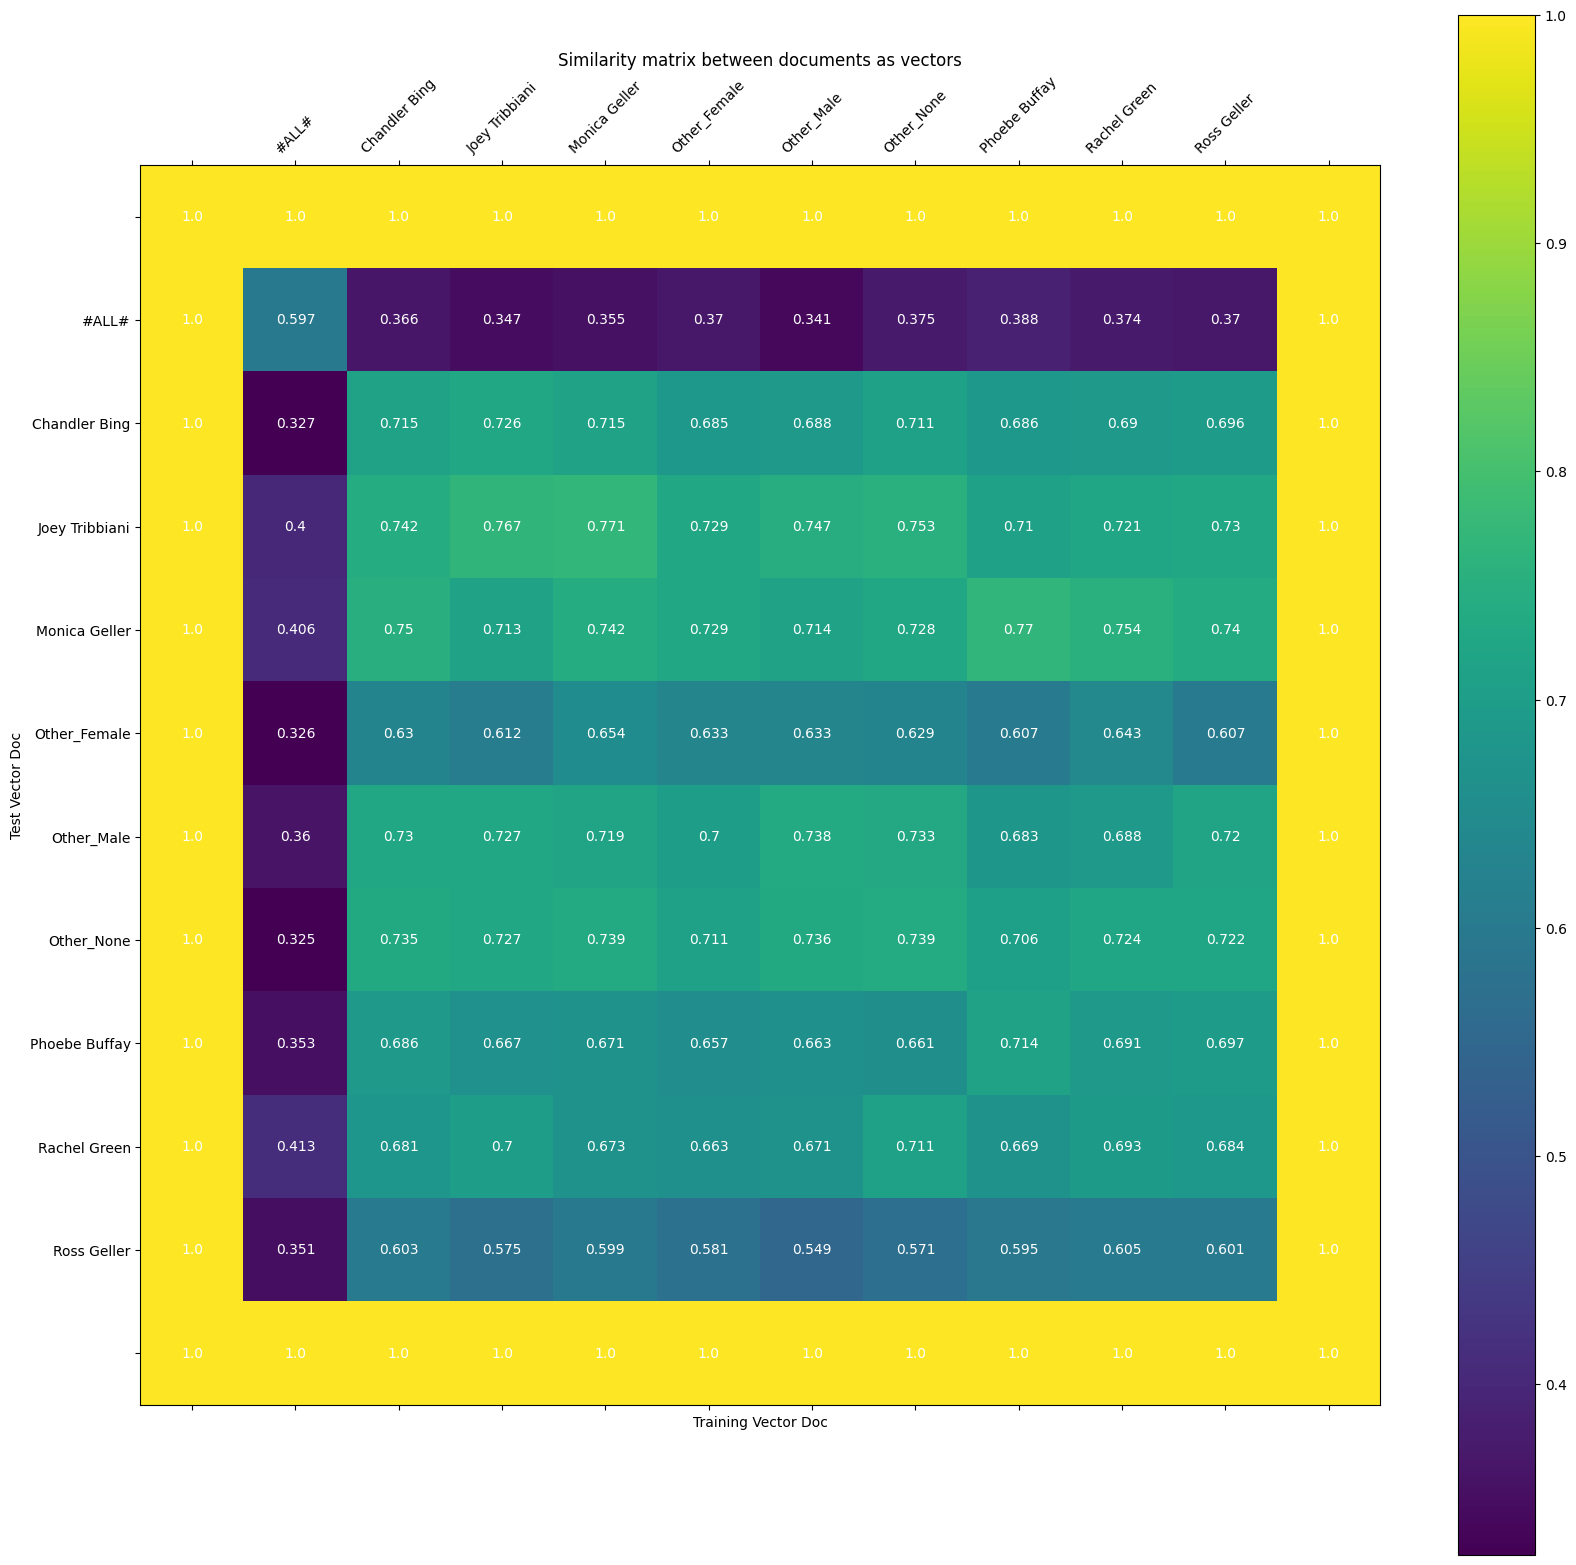

In [19]:
plot_heat_map_similarity(df)

## Grid Search

# Q4. Parameter Search (15 marks)
It is a good practice to conduct a systematic parameter search instead of a random search as this will give you more
reliable results. Given the scope of this assignment, it is possible to conduct a **grid search** on options you decided to try within the individual questions. The grid search should be done within the individual questions (i.e. Q1-Q3), and the later question should adopt the best settings from the previous questions. There is no need to do a grid search over all configurations from all questions as this will easily make the search unrealistic. E.g. Suppose we need 32, 90, and 4 runs to finish the grid search within questions, a cross-question grid search would need 32x90x4 = 11520 runs!                                                                      

*Answer 4*

In [20]:
'''
Grid Search Q1 - Preprocessing techniques
Grid search being performed with only TF-IDF as a feature without using other features
'''
from itertools import product
from sklearn.model_selection import cross_val_score

use_remove_stopwords = [True, False]
use_correct_spelling = [True, False]
use_lemmatize = [True, False]
preprocess_combinations = list(product(use_remove_stopwords, use_correct_spelling, use_lemmatize))

best_mean_rank = 10
best_preprocess_combination = None
best_accuracy = 0

for preprocess_combination in preprocess_combinations :
    remove_stopwords = preprocess_combination[0]
    spell_checker = preprocess_combination[1]
    lemmatize = preprocess_combination[2]
    print(preprocess_combination)

    training_corpus = []
    for name, doc in train_character_docs.items() :
        character_tuple = (name, [])
        for line in doc :
            processed_line = pre_process(line, remove_stopwords = remove_stopwords, spell_checker = spell_checker, lemmatize = lemmatize)
            character_tuple[1].append([processed_line])
        training_corpus.append(character_tuple)

    train_labels = [name for name, doc in training_corpus]

    # create list of pairs of (character name, pre-processed character)
    val_corpus = []
    for name, doc in val_character_docs.items() :
        character_tuple = (name, [])
        for line in doc :
            processed_line = pre_process(line, remove_stopwords = remove_stopwords, spell_checker = spell_checker, lemmatize = lemmatize)
            character_tuple[1].append([processed_line])
        val_corpus.append(character_tuple)

    val_labels = [name for name, doc in val_corpus]


    tfidfVectorizer  = TfidfVectorizer()
    train_combined_features = create_document_matrix_from_corpus(training_corpus, fitting=True, weights = [1,1,1,1], pos = False, sentiment=False, context = False, context_corpus = [])
    val_combined_features = create_document_matrix_from_corpus(val_corpus, fitting=False, weights = [1,1,1,1], pos = False, sentiment=False, context = False, context_corpus = [])

    mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(train_combined_features, val_combined_features, train_labels, val_labels)

    if mean_rank <= best_mean_rank :
        # best_weights = weights
        if acc >= best_accuracy :
            best_mean_rank = mean_rank
            best_accuracy = acc
            best_preprocess_combination = preprocess_combination

print(f"Optimal weight vector : {best_preprocess_combination}")
print(f"Optimal Mean Rank : {best_mean_rank}")
print(f"Optimal Accuracy : {best_accuracy}")



(True, True, True)
mean rank 3.5
mean cosine similarity 0.5066873304891011
5 correct out of 10 / accuracy: 0.5
(True, True, False)
mean rank 3.6
mean cosine similarity 0.5044533325047955
4 correct out of 10 / accuracy: 0.4
(True, False, True)
mean rank 2.4
mean cosine similarity 0.41939643430963763
6 correct out of 10 / accuracy: 0.6
(True, False, False)
mean rank 2.4
mean cosine similarity 0.4198048747684956
6 correct out of 10 / accuracy: 0.6
(False, True, True)
mean rank 3.2
mean cosine similarity 0.7123374697764565
3 correct out of 10 / accuracy: 0.3
(False, True, False)
mean rank 3.4
mean cosine similarity 0.7102275653012089
3 correct out of 10 / accuracy: 0.3
(False, False, True)
mean rank 2.8
mean cosine similarity 0.6885253080325202
2 correct out of 10 / accuracy: 0.2
(False, False, False)
mean rank 2.9
mean cosine similarity 0.6879610176855285
2 correct out of 10 / accuracy: 0.2
Optimal weight vector : (True, False, False)
Optimal Mean Rank : 2.4
Optimal Accuracy : 0.6


In [21]:
'''
Grid Search for Q2 & Q3
'''

# Define a range of weight values for each feature type
tfidf_weights = [0.25, 0.5, 0.75, 1.0]
# tfidf_weights = [1.0]
pos_weights = [0.25, 0.5, 0.75, 1.0]
sentiment_weights = [0.25, 0.5, 0.75, 1.0]
context_weights = [0.25, 0.5, 0.75, 1.0]

# Create a grid of weight combinations
weight_combinations = list(product(tfidf_weights, pos_weights, sentiment_weights, context_weights))
best_mean_rank = 10
best_weights = None
best_accuracy = 0

# Iterate through weight combinations and perform cross-validation
for weights in weight_combinations:
    weights = list(weights)
    print(f"current weights = {weights}")
    tfidfVectorizer  = TfidfVectorizer(ngram_range = (1,2))     #Vectorizer for tokens in character docs
    posVectorizer = TfidfVectorizer()        #Vectorizer for POS tags
    contextVectorizer = TfidfVectorizer(ngram_range = (1,2))    #Vectorizer for context doc
    train_combined_features = create_document_matrix_from_corpus(training_corpus, fitting=True, weights = weights, pos = True, sentiment=True, context = True, context_corpus = training_context_corpus)
    val_combined_features = create_document_matrix_from_corpus(val_corpus, fitting=False, weights = weights, pos = True, sentiment=True, context = True, context_corpus = val_context_corpus)

    mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(train_combined_features, val_combined_features, train_labels, val_labels)

    if mean_rank <= best_mean_rank :
        # best_weights = weights
        if acc >= best_accuracy :
            best_mean_rank = mean_rank
            best_accuracy = acc
            best_weights = weights

print(f"Optimal weight vector : {best_weights}")
print(f"Optimal Mean Rank : {best_mean_rank}")
print(f"Optimal Accuracy : {best_accuracy}")


current weights = [0.25, 0.25, 0.25, 0.25]
mean rank 3.6
mean cosine similarity 0.6574333632710074
3 correct out of 10 / accuracy: 0.3
current weights = [0.25, 0.25, 0.25, 0.5]
mean rank 4.3
mean cosine similarity 0.5657106042812797
2 correct out of 10 / accuracy: 0.2
current weights = [0.25, 0.25, 0.25, 0.75]
mean rank 5.1
mean cosine similarity 0.5237731292438287
1 correct out of 10 / accuracy: 0.1
current weights = [0.25, 0.25, 0.25, 1.0]
mean rank 5.2
mean cosine similarity 0.5041494385034782
1 correct out of 10 / accuracy: 0.1
current weights = [0.25, 0.25, 0.5, 0.25]
mean rank 3.6
mean cosine similarity 0.665113643465687
3 correct out of 10 / accuracy: 0.3
current weights = [0.25, 0.25, 0.5, 0.5]
mean rank 4.3
mean cosine similarity 0.5707119285134528
2 correct out of 10 / accuracy: 0.2
current weights = [0.25, 0.25, 0.5, 0.75]
mean rank 5.1
mean cosine similarity 0.5267984266842523
1 correct out of 10 / accuracy: 0.1
current weights = [0.25, 0.25, 0.5, 1.0]
mean rank 5.2
mean co

# Q6. Run on final test data  (10 marks)
Test your best system using the code below to train on the training data (using the first 300 lines per character maximum) and do the final testing on the test file (using the first 30 lines per character maximum).

Make any necessary adjustments such that it runs in the same way as the training/testing regime you developed above- e.g. making sure any transformer objects are initialized before `create_document_matrix_from_corpus` is called. Make sure your best system is left in the notebook and it is clear what the mean rank and accuracy of document selection are on the test data.

In [22]:
# redo on training data with the first 300 character lines used
# train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
train_character_docs, train_context_docs = create_character_document_from_dataframe(train_data, max_line_count=300, context_window = 1)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
# total_words = 0
# for name in train_character_docs.keys():
#     print(name, 'Number of Words: ',len(train_character_docs[name].split()))
#     total_words += len(train_character_docs[name].split())
# print("total words", total_words)

# training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
training_corpus = []
for name, doc in train_character_docs.items() :
    character_tuple = (name, [])
    for line in doc :
        processed_line = pre_process(line)
        character_tuple[1].append([processed_line])
    training_corpus.append(character_tuple)

train_labels = [name for name, doc in training_corpus]

#Create the training corpus of context docs
training_context_corpus = []
for name, doc in train_context_docs.items() :
    character_tuple = (name, [])
    for line in doc :
        processed_line = pre_process(line)
        character_tuple[1].append([processed_line])
    training_context_corpus.append(character_tuple)
train_labels = [name for name, doc in training_corpus]

# training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

# get the test data using 40 lines per character
# test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=30)
test_character_docs, test_context_docs = create_character_document_from_dataframe(test_data, max_line_count=300, context_window = 1)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
# total_words = 0
# for name in test_character_docs.keys():
#     print(name, 'Number of Words: ',len(test_character_docs[name].split()))
#     total_words += len(test_character_docs[name].split())
# print("total words", total_words)

# create list of pairs of (character name, pre-processed character)
# test_corpus = [(name, pre_process(doc)) for name, doc in sorted(test_character_docs.items())]
# create list of pairs of (character name, pre-processed character)
test_corpus = []
for name, doc in test_character_docs.items() :
    # if(name == '#ALL#') :
    #     continue
    character_tuple = (name, [])
    for line in doc :
        processed_line = pre_process(line)
        character_tuple[1].append([processed_line])
    test_corpus.append(character_tuple)


#Create the validation corpus of context docs
test_context_corpus = []
for name, doc in test_context_docs.items() :
    character_tuple = (name, [])
    for line in doc :
        processed_line = pre_process(line)
        character_tuple[1].append([processed_line])
    test_context_corpus.append(character_tuple)

test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
# test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)
training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True, weights = [1, 0.25, 0.5, 0.5], pos = True, sentiment=True, context = True, context_corpus = training_context_corpus)
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False, weights = [1, 0.25, 0.5, 0.5], pos = True, sentiment=True, context = True, context_corpus = val_context_corpus)


mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

Lines per character: {'Monica Geller': 300, 'Joey Tribbiani': 300, 'Chandler Bing': 300, 'Phoebe Buffay': 300, '#ALL#': 300, 'Ross Geller': 300, 'Rachel Green': 300, 'Other_None': 300, 'Other_Female': 300, 'Other_Male': 300}
Num. Characters:  10 

Lines per character: {'Ross Geller': 300, 'Joey Tribbiani': 300, 'Chandler Bing': 300, 'Other_Female': 190, 'Other_None': 300, '#ALL#': 11, 'Monica Geller': 300, 'Rachel Green': 300, 'Phoebe Buffay': 300, 'Other_Male': 201}
Num. Characters:  10 

mean rank 2.8
mean cosine similarity 0.7007099116617793
4 correct out of 10 / accuracy: 0.4
